### Cell 1 - Imports

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam

/Users/conorwoollatt/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Cell 2 - Processing the file

In [2]:
genres = ['classical', 'metal']
# Load the CSV file
data = pd.read_csv("all_30_second_features_full.csv")
data = data.drop(columns=["song_id"], errors='ignore') # Drop the index column if it exists

# Filter to only pop and disco genres
data = data[data['label'].isin(genres)].copy()
print(f"Total samples after genre filtering: {len(data)}")

# Limit to maximum 2000 samples total
if len(data) > 2000:
    # Sample 2000 rows while maintaining genre balance
    disco_samples = data[data['label'] == 'classical']
    pop_samples = data[data['label'] == 'metal']
    
    # Calculate samples per genre (aim for balanced)
    samples_per_genre = min(1000, len(disco_samples), len(pop_samples))
    
    # Sample from each genre
    disco_sampled = disco_samples.sample(n=min(samples_per_genre, len(disco_samples)), random_state=42)
    pop_sampled = pop_samples.sample(n=min(samples_per_genre, len(pop_samples)), random_state=42)
    
    # Combine and shuffle
    data = pd.concat([disco_sampled, pop_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)
    
    # If we still have more than 2000, take exactly 2000
    if len(data) > 2000:
        data = data.sample(n=2000, random_state=42).reset_index(drop=True)

print(f"Final dataset size: {len(data)}")
print(f"Genre distribution: {data['label'].value_counts()}")

# Extract song IDs from filenames
data['song_id'] = data['filename'].apply(lambda x: x.rsplit('.', 2)[0]) # Extract "blues.00000" from "blues.00000.0.wav"

# Group clips by song ID
song_to_clips = {}
for song_id, group in data.groupby('song_id'):
    # Store all features and labels for each clip
    song_to_clips[song_id] = {
        'features': group.drop(columns=['filename', 'song_id', 'label']).values, # Extract features (all columns except filename, song_id, and label)
        'labels': group['label'].values # Extract labels
    }

# Split song IDs into training and test sets
song_ids = list(song_to_clips.keys())
train_ids, test_ids = train_test_split(song_ids, test_size=0.2, random_state=42)

print(f"Number of unique songs: {len(song_ids)}")
print(f"Songs in training: {len(train_ids)}")
print(f"Songs in test: {len(test_ids)}")

# Prepare training and test data
X_train, y_train, X_test, y_test = [], [], [], []

# Assign clips based on the train-test split
for song_id in song_ids:
    clips = song_to_clips[song_id]
    if song_id in train_ids:
        X_train.extend(clips['features']) # Add all features for this song to the training set
        y_train.extend(clips['labels']) # Add all labels for this song to the training set
    else:
        X_test.extend(clips['features']) # Add all features for this song to the test set
        y_test.extend(clips['labels']) # Add all labels for this song to the test set

# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Print shapes to verify
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"Total samples: {len(X_train) + len(X_test)}")
print(f"Training set genre distribution: {np.unique(y_train, return_counts=True)}")
print(f"Test set genre distribution: {np.unique(y_test, return_counts=True)}")

# Keep X and y as original full feature matrix and labels
X = data.drop(columns=["label", "filename", "song_id"])
y = data["label"]
print(f"X shape: {X.shape}, y shape: {y.shape}")

Total samples after genre filtering: 200
Final dataset size: 200
Genre distribution: label
classical    100
metal        100
Name: count, dtype: int64
Number of unique songs: 2
Songs in training: 1
Songs in test: 1
X_train shape: (100, 309), y_train shape: (100,)
X_test shape: (100, 309), y_test shape: (100,)
Total samples: 200
Training set genre distribution: (array(['classical'], dtype='<U9'), array([100]))
Test set genre distribution: (array(['metal'], dtype='<U5'), array([100]))
X shape: (200, 309), y shape: (200,)


### Cell 3 - Feature extraction

In [3]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


# new data frame with the new scaled data. 
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

X = pd.DataFrame(np_scaled, columns = cols)
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X)
X = np.concatenate((X, pca.fit_transform(X)), axis=1)


X.shape

(200, 312)

### Cell 5 - Train test split

In [4]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

# One-hot encode the labels
y_train_encoded = to_categorical(y_train, num_classes=len(genres))
y_test_encoded = to_categorical(y_test, num_classes=len(genres))

# Check the shapes of the train and test sets - commented out for readability
# Uncomment to see the shape and number of files read in

# print(f"Shape of x_train: {x_train.shape}")
# print(f"Shape of x_test: {x_test.shape}")
# print(f"Shape of y_train: {y_train.shape}")
# print(f"Shape of y_test: {y_test.shape}")
# print(f"Shape of y_train_encoded: {y_train_encoded.shape}")
# print(f"Shape of y_test_encoded: {y_test_encoded.shape}")


In [5]:
print(X_test_scaled.shape)
print(X_train_scaled.shape)

(40, 312)
(160, 312)


### Cell 7 - Training SVM model

In [6]:
from sklearn.calibration import CalibratedClassifierCV
svm_model = SVC(
    C=100,
    kernel='rbf',
    gamma='scale',
    probability=True,
    random_state=42,
)

# Calibration for better probabilities (optional)
calibrated_svm = CalibratedClassifierCV(svm_model, cv=3, method='sigmoid')

# Train
svm_model.fit(X_train_scaled, y_train)

# Evaluate
y_pred_svm = svm_model.predict(X_test_scaled)
y_proba_svm = svm_model.predict_proba(X_test_scaled)

print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.3f}")

Accuracy: 1.000


### Cell 8 - Defining CNN

In [7]:
# Define the CNN model architecture
cnn_model = Sequential([
    # First convolutional layer with 'same' padding
    layers.Input(shape = (x_train.shape[1],1)),
    layers.Conv1D(64, 3, activation='relu', padding='same',),
    layers.MaxPooling1D(2, padding='same'),  # MaxPooling2D with same padding

    # Second convolutional layer with 'same' padding
    layers.Conv1D(128, 3, activation='relu', padding='same'),
    layers.MaxPooling1D(2, padding='same'),

    # Third convolutional layer with 'same' padding
    layers.Conv1D(256, 3, activation='relu', padding='same'),
    layers.MaxPooling1D(2, padding='same'),

    # Flatten the output of the convolutional layers
    layers.Flatten(),

    # Fully connected layers
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),

    # Output layer with softmax activation
    layers.Dense(len(genres), activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Summarize the model architecture
#cnn_model.summary()
print("Model compiled")


Model compiled


### Cell 9 - Training CNN model

In [8]:
# Train the CNN model
cnn_model.fit(x_train, y_train_encoded, validation_data=(x_test, y_test_encoded), epochs=30, batch_size=32)


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.7077 - loss: 0.6255 - val_accuracy: 0.7750 - val_loss: 0.3175
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9012 - loss: 0.3118 - val_accuracy: 1.0000 - val_loss: 0.0535
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9949 - loss: 0.0730 - val_accuracy: 1.0000 - val_loss: 0.0049
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9872 - loss: 0.0374 - val_accuracy: 1.0000 - val_loss: 5.8091e-04
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9966 - loss: 0.0107 - val_accuracy: 1.0000 - val_loss: 1.9301e-04
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9871 - loss: 0.0221 - val_accuracy: 1.0000 - val_loss: 1.5711e-04
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 1.0000 - val_loss: 1.2839e-04
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9923 - loss: 0.0088 - val_accuracy: 1.0000 - v

### Training a Dense Neural Network

In [9]:
import tensorflow as tf
# Define an enhanced MLP architecture with better regularization and optimization
def create_mlp(input_shape, num_classes):
    model = Sequential([
        layers.Input(shape=input_shape),
        
        # Hidden layers with batch norm and dropout
        layers.Dense(1024, activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(512, activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(256, activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Additional hidden layer
        layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])

    
    model.compile(
        optimizer="Adam",
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

mlp_model = create_mlp((x_train.shape[1],), len(genres))
mlp_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 1024)           │       320,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,017,474 (3.88 MB)

 Trainable params: 1,013,634 (3.87 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Add callbacks for better training
mlp_callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
]

mlp_model.fit(
    x_train, y_train_encoded,
    validation_data=(x_test, y_test_encoded),
    epochs=30,
    batch_size=128,  # Larger batch size
    callbacks=mlp_callbacks,
)

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.4318 - loss: 1.1295 - val_accuracy: 0.9750 - val_loss: 0.3024 - learning_rate: 0.0010
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9661 - loss: 0.1159 - val_accuracy: 0.9750 - val_loss: 0.2146 - learning_rate: 0.0010
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9891 - loss: 0.0498 - val_accuracy: 0.9750 - val_loss: 0.1661 - learning_rate: 0.0010
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 0.0260 - val_accuracy: 0.9750 - val_loss: 0.1307 - learning_rate: 0.0010
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.0155 - val_accuracy: 1.0000 - val_loss: 0.1037 - learning_rate: 0.0010
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0082 - val_accuracy: 1.0000 - val_loss: 0.0836 - learning_rate: 0.0010
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0065 - val_accuracy: 1.0000

In [11]:
y_pred_cnn = mlp_model.predict(x_test)
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)
accuracy_cnn = accuracy_score(y_test, y_pred_cnn)
print(f"Accuracy (CNN): {accuracy_cnn:.3f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Accuracy (CNN): 1.000


### Cell 10 - XGBoost model 

In [12]:
xgb_model = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.05)
xgb_model.fit(x_train, y_train)
y_pred_xgb = xgb_model.predict(x_test)

### Random forest model

In [13]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Train the model
rf_model.fit(x_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(x_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_rf:.3f}")

Accuracy: 1.000


In [14]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Train the model
rf_model.fit(x_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(x_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_rf:.3f}")

Accuracy: 1.000


### Cell 11 - Evaluate models

In [15]:
# Predict using the CNN model
y_pred_cnn = cnn_model.predict(x_test)
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)
y_pred_mlp = mlp_model.predict(x_test)
y_pred_mlp = np.argmax(y_pred_mlp, axis=1)

# Calculate accuracy
accuracy_cnn = accuracy_score(y_test, y_pred_cnn)
print(f"Accuracy (CNN): {accuracy_cnn:.3f}")

accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print(f"Accuracy (DNN): {accuracy_mlp:.3f}")

accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy (SVM): {accuracy_svm:.3f}")

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy (RFC): {accuracy_rf:.3f}")

xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy (XGB): {xgb_accuracy:.3f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Accuracy (CNN): 1.000
Accuracy (DNN): 1.000
Accuracy (SVM): 1.000
Accuracy (RFC): 1.000
Accuracy (XGB): 1.000


### Cell 12 - Creating an ensemble using soft voting

In [16]:
# Get predictions from each model
xgb_preds_proba = xgb_model.predict_proba(x_test)
rf_preds_proba = rf_model.predict_proba(x_test)
svm_preds_proba = svm_model.predict_proba(X_test_scaled)
cnn_preds_proba = cnn_model.predict(x_test)
mlp_preds_proba = mlp_model.predict(x_test)

# Average the predictions (soft voting)
avg_preds_proba = (xgb_preds_proba + svm_preds_proba + cnn_preds_proba +  rf_preds_proba + mlp_preds_proba) / 5

# Convert probabilities to class predictions
ensemble_preds = np.argmax(avg_preds_proba, axis=1)

# Evaluate the ensemble performance
soft_ensemble_accuracy = accuracy_score(y_test, ensemble_preds)
print(f"Ensemble Accuracy: {soft_ensemble_accuracy:.3f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Ensemble Accuracy: 1.000


In [17]:
print(y_pred_svm)
print(y_pred_cnn)

[0 0 0 1 1 1 0 1 1 0 0 1 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 1
 1 1 0]
[0 0 0 1 1 1 0 1 1 0 0 1 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 1
 1 1 0]


In [18]:
print("The predictions before averaging", avg_preds_proba.shape)
print("The predictions after averaging", ensemble_preds.shape)

The predictions before averaging (40, 2)
The predictions after averaging (40,)


### Cell 13 - Creating an ensemble using hard voting

In [19]:
from scipy.stats import mode
from sklearn.metrics import accuracy_score
import numpy as np

# Step 1: Get class predictions from each model
xgb_preds = xgb_model.predict(x_test)  # Class labels
rf_preds = rf_model.predict(x_test)
svm_preds = svm_model.predict(X_test_scaled)
cnn_preds = np.argmax(cnn_model.predict(x_test), axis=1)  # Convert CNN probs to class labels
mlp_preds = np.argmax(mlp_model.predict(x_test), axis=1)  # Convert DNN probs to class labels


# Step 2: Stack predictions
all_preds = np.array([xgb_preds, svm_preds, cnn_preds, rf_preds + mlp_preds])  # Shape: (3, num_samples)

# Step 3: Perform majority voting (hard voting)
ensemble_preds, _ = mode(all_preds, axis=0, keepdims=True)  # Get most common class per sample
ensemble_preds = ensemble_preds.flatten()  # Convert to 1D array

# Step 4: Evaluate accuracy
hard_ensemble_accuracy = accuracy_score(y_test, ensemble_preds)
print(f"Hard Voting Ensemble Accuracy: {hard_ensemble_accuracy:.3f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Hard Voting Ensemble Accuracy: 1.000


In [20]:
from itertools import combinations
# Stack all predictions into a 2D array (5 models × 1998 samples)
all_preds = np.vstack([xgb_preds, rf_preds, svm_preds, cnn_preds, mlp_preds])
full_consensus_mask = np.all(all_preds == all_preds[0, :], axis=0)  # Compare all rows to 1st row (XGB)
num_full_consensus = np.sum(full_consensus_mask)
print(f"Number of samples where all 5 models agree: {num_full_consensus}/{len(x_test)}")

models = ['XGBoost', 'Random Forest', 'SVM', 'CNN', 'MLP']
preds_list = [xgb_preds, rf_preds, svm_preds, cnn_preds, mlp_preds]

# Compare every pair of models
for (i, name1), (j, name2) in combinations(zip(range(5), models), 2):
    matches = np.sum(preds_list[i] == preds_list[j])
    print(f"{name1} vs {name2}: {matches}/{len(x_test)} ({matches/len(x_test):.1%} agreement)")

Number of samples where all 5 models agree: 40/40
XGBoost vs Random Forest: 40/40 (100.0% agreement)
XGBoost vs SVM: 40/40 (100.0% agreement)
XGBoost vs CNN: 40/40 (100.0% agreement)
XGBoost vs MLP: 40/40 (100.0% agreement)
Random Forest vs SVM: 40/40 (100.0% agreement)
Random Forest vs CNN: 40/40 (100.0% agreement)
Random Forest vs MLP: 40/40 (100.0% agreement)
SVM vs CNN: 40/40 (100.0% agreement)
SVM vs MLP: 40/40 (100.0% agreement)
CNN vs MLP: 40/40 (100.0% agreement)


In [21]:
print("The predictions before averaging", all_preds.shape)
print("The predictions after averaging", ensemble_preds.shape)

The predictions before averaging (5, 40)
The predictions after averaging (40,)


### Weighted voting

In [22]:
import numpy as np
from sklearn.metrics import accuracy_score

# Define the weights based on model accuracies
weights = {
    'mlp': accuracy_mlp,
    'cnn': accuracy_cnn,
    'svm': accuracy_svm,
    'rf': accuracy_rf,
    'xgb': xgb_accuracy
}

# Normalize the weights so they sum to 1
total_weight = sum(weights.values())
weights = {k: v / total_weight for k, v in weights.items()}

# Get predictions from each model
xgb_preds_proba = xgb_model.predict_proba(x_test)
rf_preds_proba = rf_model.predict_proba(x_test)
svm_preds_proba = svm_model.predict_proba(X_test_scaled)
cnn_preds_proba = cnn_model.predict(x_test)
mlp_preds_proba = cnn_model.predict(x_test)


# Apply weights to the predicted probabilities
weighted_xgb_proba = xgb_preds_proba * weights['xgb']
weighted_rf_proba = rf_preds_proba * weights['rf']
weighted_svm_proba = svm_preds_proba * weights['svm']
weighted_cnn_proba = cnn_preds_proba * weights['cnn']
weighted_mlp_proba = mlp_preds_proba * weights['cnn']


# Combine the weighted probabilities
weighted_avg_proba = weighted_xgb_proba +  weighted_cnn_proba + weighted_svm_proba + weighted_rf_proba + weighted_mlp_proba

# Convert weighted probabilities to class predictions
weighted_ensemble_preds = np.argmax(weighted_avg_proba, axis=1)

# Evaluate the weighted ensemble performance
weighted_ensemble_accuracy = accuracy_score(y_test, weighted_ensemble_preds)
print(f"Weighted Ensemble Accuracy: {weighted_ensemble_accuracy:.3f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Weighted Ensemble Accuracy: 1.000


In [23]:
y_test[1]

np.int64(0)

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Step 1: Get predictions from base models
xgb_train_preds = xgb_model.predict_proba(x_train)
rf_train_preds = rf_model.predict_proba(x_train)
svm_train_preds = svm_model.predict_proba(X_train_scaled)
cnn_train_preds = cnn_model.predict(x_train)
mlp_train_preds = mlp_model.predict(x_train)

xgb_test_preds = xgb_model.predict_proba(x_test)
rf_test_preds = rf_model.predict_proba(x_test)
svm_test_preds = svm_model.predict_proba(X_test_scaled)
cnn_test_preds = cnn_model.predict(x_test)
mlp_test_preds = mlp_model.predict(x_test)

# Step 2: Create new dataset for meta-model training
stacked_train = np.hstack((xgb_train_preds, svm_train_preds, cnn_train_preds,  rf_train_preds + mlp_train_preds))
stacked_test = np.hstack((xgb_test_preds, svm_test_preds, cnn_test_preds, rf_test_preds + mlp_test_preds))

# Step 3: Train meta-model
meta_model = LogisticRegression()
meta_model.fit(stacked_train, y_train)

# Step 4: Predict with the meta-model
ensemble_preds = meta_model.predict(stacked_test)

# Step 5: Evaluate performance
stack_ensemble_accuracy = accuracy_score(y_test, ensemble_preds)
print(f"Stacking Ensemble Accuracy: {stack_ensemble_accuracy:.3f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Stacking Ensemble Accuracy: 1.000


In [25]:
first = stacked_test[0]

print("Model 1:", first[:10])
print("Model 2:", first[10:20])
print("Model 3:", first[20:30])
print("Model 4:", first[30:40])

Model 1: [9.87437308e-01 1.25627182e-02 9.98889712e-01 1.11028843e-03
 1.00000000e+00 5.39212286e-10 1.99748325e+00 2.51675630e-03]
Model 2: []
Model 3: []
Model 4: []


In [26]:
stacked_test.shape

(40, 8)

### Print all accuracies

In [27]:
print(f"Accuracy (CNN): {accuracy_cnn:.3f}")
print(f"Accuracy (DNN): {accuracy_mlp:.3f}")
print(f"Accuracy (SVM): {accuracy_svm:.3f}")
print(f"Accuracy (RFC): {accuracy_rf:.3f}")
print(f"Accuracy (XGB): {xgb_accuracy:.3f}")

print()

print(f"Weighted Ensemble Accuracy: {weighted_ensemble_accuracy:.3f}")
print(f"Hard Voting Ensemble Accuracy: {hard_ensemble_accuracy:.3f}")
print(f"Soft Voting Accuracy: {soft_ensemble_accuracy:.3f}")
print(f"Stacking Ensemble Accuracy: {stack_ensemble_accuracy:.3f}")

Accuracy (CNN): 1.000
Accuracy (DNN): 1.000
Accuracy (SVM): 1.000
Accuracy (RFC): 1.000
Accuracy (XGB): 1.000

Weighted Ensemble Accuracy: 1.000
Hard Voting Ensemble Accuracy: 1.000
Soft Voting Accuracy: 1.000
Stacking Ensemble Accuracy: 1.000


### Creating a confusion matrix for the ensemble

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


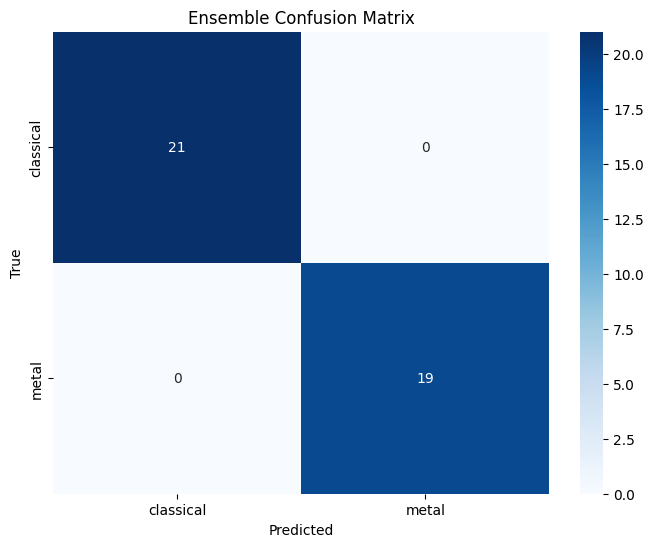

In [28]:
# Get predictions from each model (XGBoost, SVM, CNN)
xgb_preds = xgb_model.predict(x_test)
svm_preds = svm_model.predict(x_test)
rf_preds = rf_model.predict(x_test)
cnn_preds = np.argmax(cnn_model.predict(x_test), axis=1)

# Soft Voting: average the predicted probabilities
xgb_probs = xgb_model.predict_proba(x_test)
svm_probs = svm_model.predict_proba(x_test)
rf_probs = rf_model.predict_proba(x_test)
cnn_probs = cnn_model.predict(x_test)

# Average the probabilities (soft voting)
ensemble_probs = (xgb_probs + svm_probs + cnn_probs + rf_probs) / 4
ensemble_preds = np.argmax(ensemble_probs, axis=1)
ensemble_cm = confusion_matrix(y_test, ensemble_preds)

# Plot the confusion matrix for the ensemble model
plt.figure(figsize=(8, 6))
sns.heatmap(ensemble_cm, annot=True, fmt="d", cmap="Blues", xticklabels=genres, yticklabels=genres)
plt.title("Ensemble Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


### Creating a confusion matrix for CNN

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


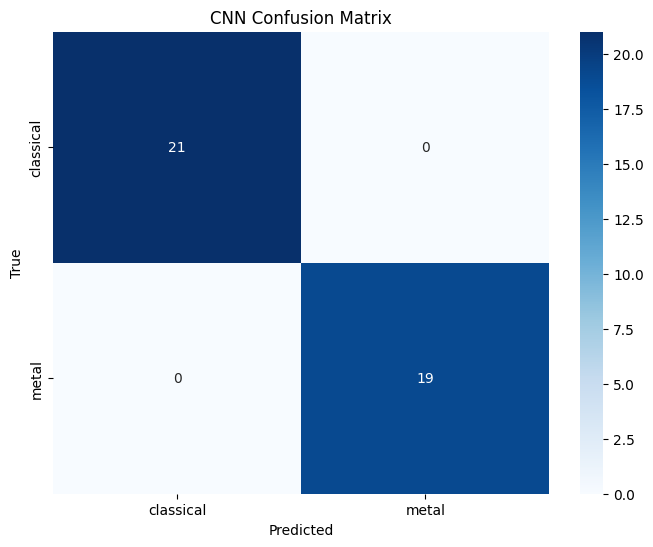

In [29]:
plt.clf
cnn_preds = np.argmax(cnn_model.predict(x_test), axis=1)
cnn_cm = confusion_matrix(y_test, cnn_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cnn_cm, annot=True, fmt="d", cmap="Blues", xticklabels=genres, yticklabels=genres)
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


### Creating a confusion matrix for XGB

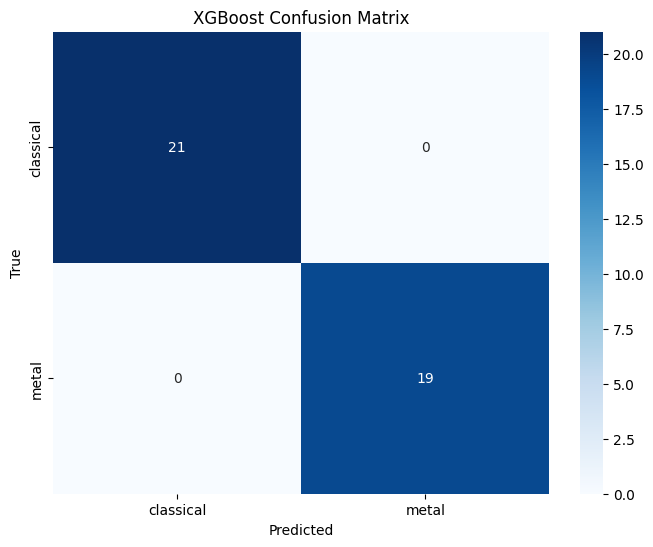

In [30]:
plt.clf
xgb_preds = xgb_model.predict(x_test)
xgb_cm = confusion_matrix(y_test, xgb_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(xgb_cm, annot=True, fmt="d", cmap="Blues", xticklabels=genres, yticklabels=genres)
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
